In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os

In [3]:
im = cv2.imread('../test-images/a-48.jpg')
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5,5), 0)
edges = cv2.Canny(blurred, 50,150,apertureSize = 3)
edges_cropped = edges[600:, :]
blurred_cropped = blurred[600:, :]
(T, threshinv) = cv2.threshold(blurred_cropped, 200, 255, cv2.THRESH_BINARY_INV)

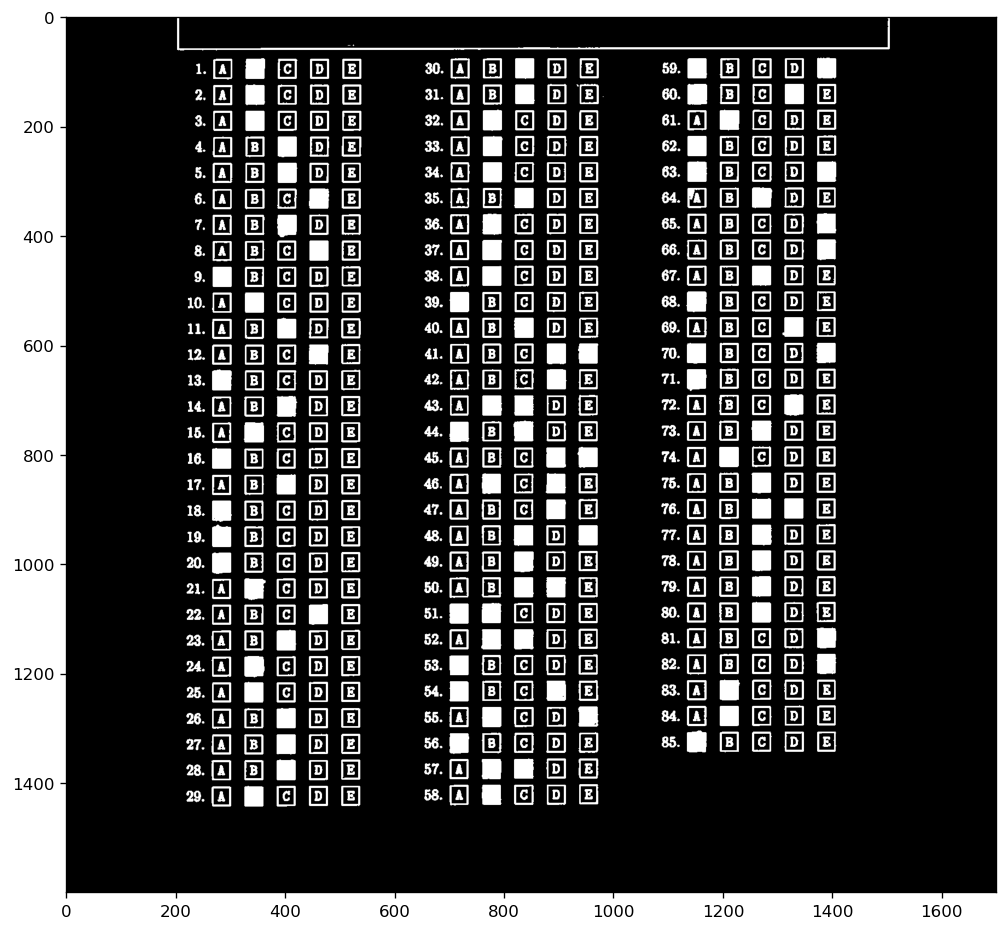

In [4]:
plt.figure(figsize=(10,16))
plt.imshow(threshinv, cmap='gray')

In [5]:
def slope_close_to(theta, theta_0, tol=5):
    # theta - rad
    # theta_0 - deg
    # tol - deg
    # deg angles range from [-90,90], theta is converted to this scale
    theta_1 = (180/np.pi)*theta.copy()
    theta_1[theta_1>90] = theta_1[theta_1>90]-180
    return np.isclose(theta_1, theta_0, atol=tol)

In [6]:
def show_lines(img, lines, title='img'):
    fig, axes = plt.subplots(figsize=(10,16))
    axes.imshow(img, cmap='gray')
    d = max(img.shape)
    for rho,theta in lines:
        dx = np.cos(theta)
        dy = np.sin(theta)
        x0 = dx*rho
        y0 = dy*rho
        # (x0,y0) is a point on the line
        # print(x0,y0)
        x1 = int(x0 + d*(-dy))
        y1 = int(y0 + d*(dx))
        x2 = int(x0 - d*(-dy))
        y2 = int(y0 - d*(dx))
        # print(x1,y1,x2,y2)
        axes.plot([x1,x2], [y1,y2], '-.', color='red', alpha=0.7)
    axes.set_xlim(0, img.shape[1]) # x is cols
    axes.set_ylim(img.shape[0], 0) # y is rows
    axes.set_title(title)

In [7]:
def merge_lines(lines, ro_tol=2):
    # lines: nx2 matrix, first column is ro and second column is theta
    # parallel lines
    # keeps the left most line
    # returns a mask that works on sorted lines on ro
    
    sorted_ros = lines[:,0]
    
    mask = np.zeros(lines.shape[0], dtype=np.bool8)
    
    if len(lines) == 0:
        return mask

    mask[0] = True
    prev_ro = sorted_ros[0]
    
    for i,ro in enumerate(sorted_ros[1:]):
        i+=1
        if np.isclose(ro, prev_ro, atol=ro_tol):
            continue
        else:
            mask[i] = True
            prev_ro = ro
            
    return mask

In [8]:
def merge_lines2(lines, min_gap=10):
    # lines: nx2 matrix, first column is ro and second column is theta
    # parallel lines
    # keeps the left most line
    # returns a mask that works on sorted lines on ro
    
    sorted_ros = lines[:,0]
    
    mask = np.zeros(lines.shape[0], dtype=np.bool8)
    
    if len(lines) == 0:
        return mask

    mask[0] = True
    prev_ro = sorted_ros[0]
    prev_i = 0
    
    for i,ro in enumerate(sorted_ros[1:], start=1):
        gap = abs(ro-prev_ro)
        if gap > min_gap:
            # print(prev_i, i, prev_ro, ro, gap)
            mask[prev_i] = True
            mask[i] = True
        prev_ro, prev_i = ro, i
            
    mask[i] = True # last line
    return mask

In [21]:
lines = np.abs(cv2.HoughLines(threshinv, 1/4, np.pi/(4*180), 300).squeeze())
sorted_lines = lines[np.argsort(lines[:,0])]
vertical_lines = sorted_lines[slope_close_to(sorted_lines[:,1], 0, tol=15)]
vertical_lines_merged = vertical_lines[merge_lines2(vertical_lines, min_gap=10)]

horizontal_lines = sorted_lines[slope_close_to(sorted_lines[:,1], 90, tol=15)]
horizontal_lines_merged = horizontal_lines[merge_lines(horizontal_lines, ro_tol=10)]

In [22]:
print(sorted_lines.shape)
print('vertical_lines', vertical_lines.shape)
print('vertical_lines_merged', vertical_lines_merged.shape)

print('horizontal_lines', horizontal_lines.shape)
print('horizontal_lines_merged', horizontal_lines_merged.shape)

(1464, 2)
vertical_lines (578, 2)
vertical_lines_merged (36, 2)
horizontal_lines (779, 2)
horizontal_lines_merged (111, 2)


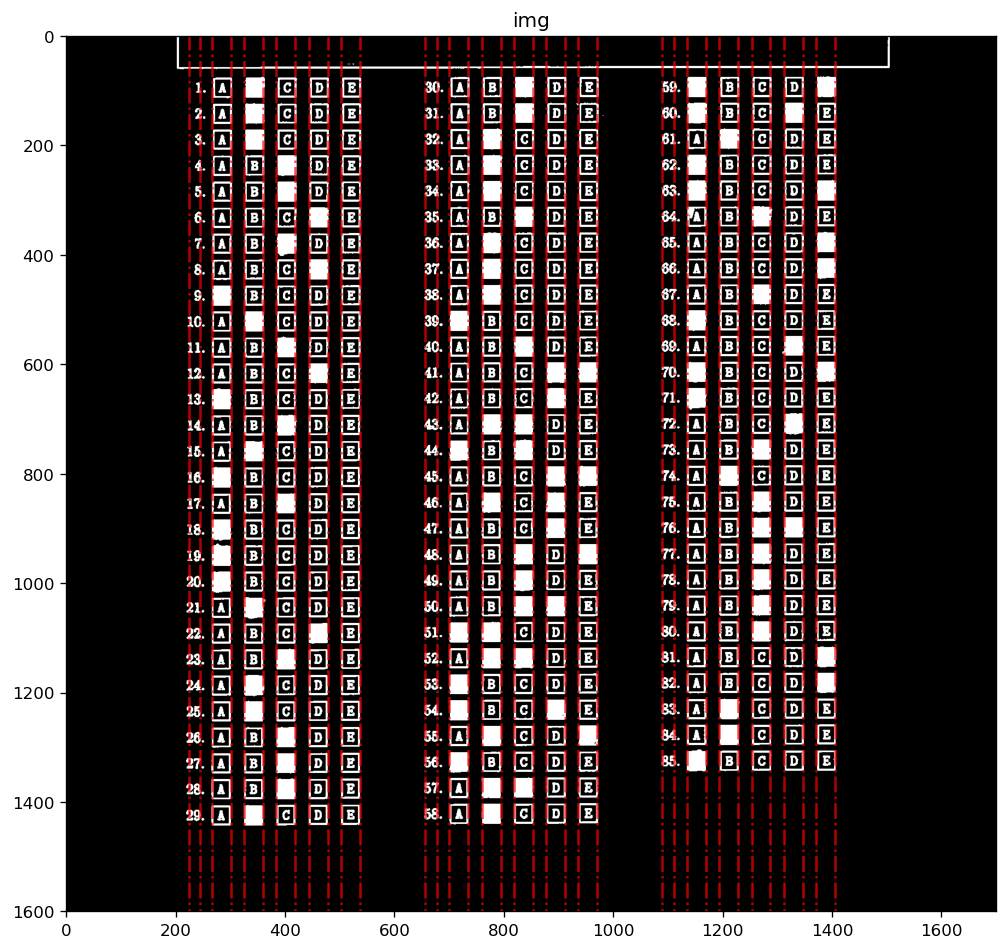

In [24]:
show_lines(threshinv, vertical_lines_merged)

In [105]:
lines = np.abs(cv2.HoughLines(threshinv,1/4,np.pi/(4*180),250).squeeze())
sorted_lines = lines[np.argsort(lines[:,0])]
vertical_lines = sorted_lines[slope_close_to(sorted_lines[:,1], 0, tol=15)]
vertical_lines_merged = vertical_lines[merge_lines(vertical_lines, ro_tol=5)]

horizontal_lines = sorted_lines[slope_close_to(sorted_lines[:,1], 90, tol=15)]
horizontal_lines_merged = horizontal_lines[merge_lines2(horizontal_lines, 10)]

In [106]:
print(sorted_lines.shape)
print('vertical_lines', vertical_lines.shape)
print('vertical_lines_merged', vertical_lines_merged.shape)

print('horizontal_lines', horizontal_lines.shape)
print('horizontal_lines_merged', horizontal_lines_merged.shape)

(2211, 2)
vertical_lines (614, 2)
vertical_lines_merged (217, 2)
horizontal_lines (902, 2)
horizontal_lines_merged (62, 2)


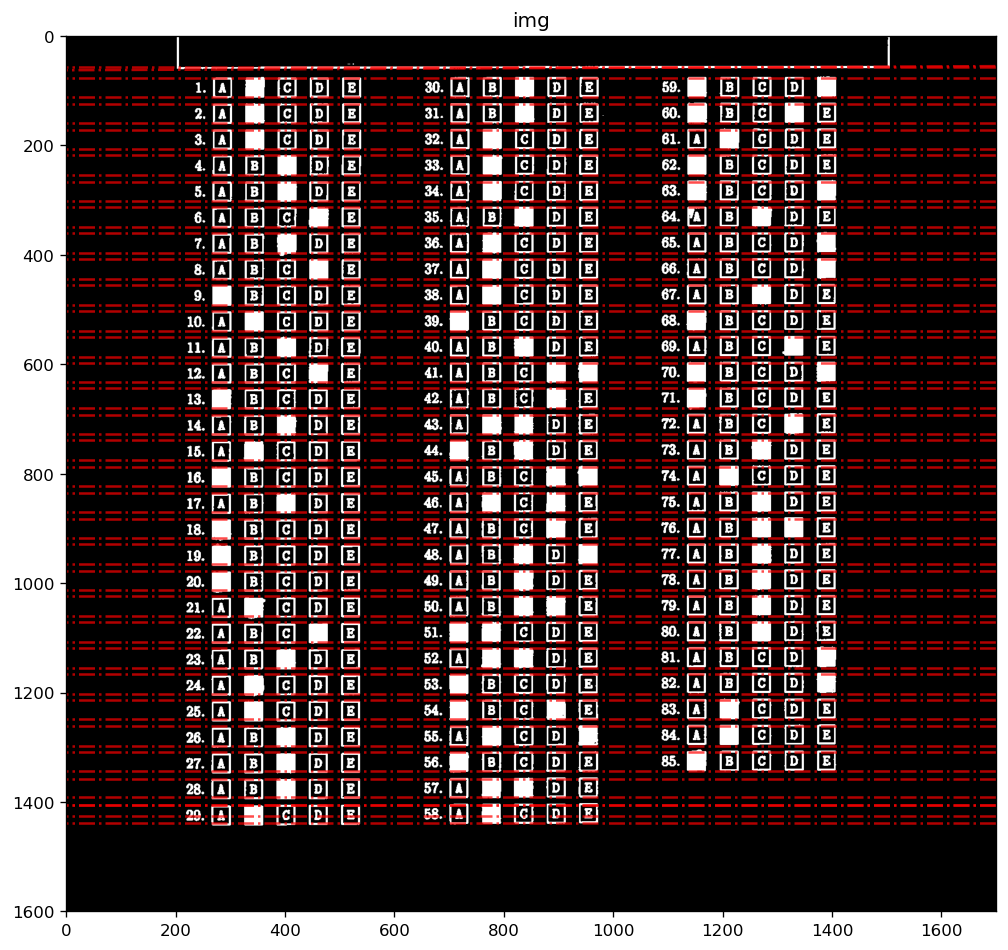

In [107]:
show_lines(threshinv, horizontal_lines_merged)

In [11]:
def patches(img, vertical_lines, stack, sub_stack, col=None):
    y1,y2 = 0,img.shape[0]
    
    if sub_stack == 0:
        x1= 0 if stack==0 else int(vertical_lines[22*stack-1,0])
        x2=int(vertical_lines[22*stack,0])
    elif sub_stack == 1:
        x1=int(vertical_lines[22*stack,0])
        x2=int(vertical_lines[22*stack+2,0])
    else:
        if col is None:
            x1=int(vertical_lines[22*stack+2,0])
            x2=int(vertical_lines[22*stack+21,0])
        else:
            x1=int(vertical_lines[22*stack+2+4*col,0])
            x2=int(vertical_lines[22*stack+2+4*col+3,0])
    
    print(x1,x2,y1,y2)
    return img[y1:y2, x1:x2]

In [45]:
plt.imsave('patch2.jpg', p, cmap='gray')

1194 1227 0 1600


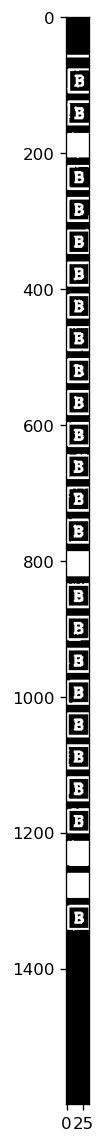

In [44]:
p = patches(threshinv, vertical_lines_merged, 2, 2, 1)
plt.figure(figsize=(10,12))
plt.imshow(p, cmap='gray')
# plt.axis('off')
# plt.savefig('patch.jpg')

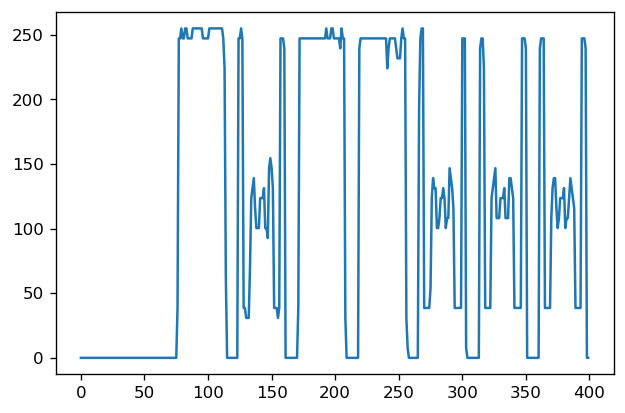

In [357]:
# plt.plot(np.arange(200), np.sum(p[:200,:], axis=1))
plt.plot(np.arange(400), np.sum(p[:400,:], axis=1)/p.shape[1])

In [339]:
def and_morphology(img_, f):
    img = img_.copy().astype(np.bool8)
    kernel = np.ones((f,f)).astype(np.bool8)
    h,w=img.shape
    res = np.zeros((h-f+1, w+f-1), np.uint8)
    print(w-f+1, h-f+1)
    print(w,h)
    for x in range(w-f+1):
        for y in range(h-f+1):
            res[y,x] = 255 if np.all(img[y:y+f, x:x+f] & kernel) else 0
    return res

pf = and_morphology(p, 9)

25 1592
33 1600


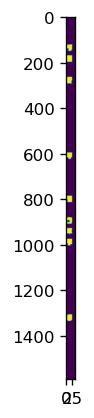

In [340]:
plt.imshow(pf)

(1600, 268) (1600, 268)


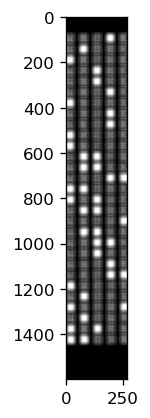

In [265]:
kernel1 = np.ones((20,20))
# kernel1[2:38, 2:38] = 0
kernel1 = kernel1/np.sum(kernel1)
pf = cv2.filter2D(src=p, ddepth=-1, kernel=kernel1)
plt.imshow(pf, cmap='gray')

print(p.shape, pf.shape)

In [238]:
lines = np.abs(cv2.HoughLines(p,1/4,np.pi/(4*180),85).squeeze())
sorted_lines = lines[np.argsort(lines[:,0])]
vertical_lines = sorted_lines[slope_close_to(sorted_lines[:,1], 0, tol=15)]
vertical_lines_merged = vertical_lines[merge_lines(vertical_lines, ro_tol=5)]

horizontal_lines = sorted_lines[slope_close_to(sorted_lines[:,1], 90, tol=15)]
horizontal_lines_merged = horizontal_lines[merge_lines(horizontal_lines, ro_tol=10)]

In [239]:
print(sorted_lines.shape)
print('vertical_lines', vertical_lines.shape)
print('vertical_lines_merged', vertical_lines_merged.shape)

print('horizontal_lines', horizontal_lines.shape)
print('horizontal_lines_merged', horizontal_lines_merged.shape)

(15718, 2)
vertical_lines (12437, 2)
vertical_lines_merged (75, 2)
horizontal_lines (890, 2)
horizontal_lines_merged (116, 2)


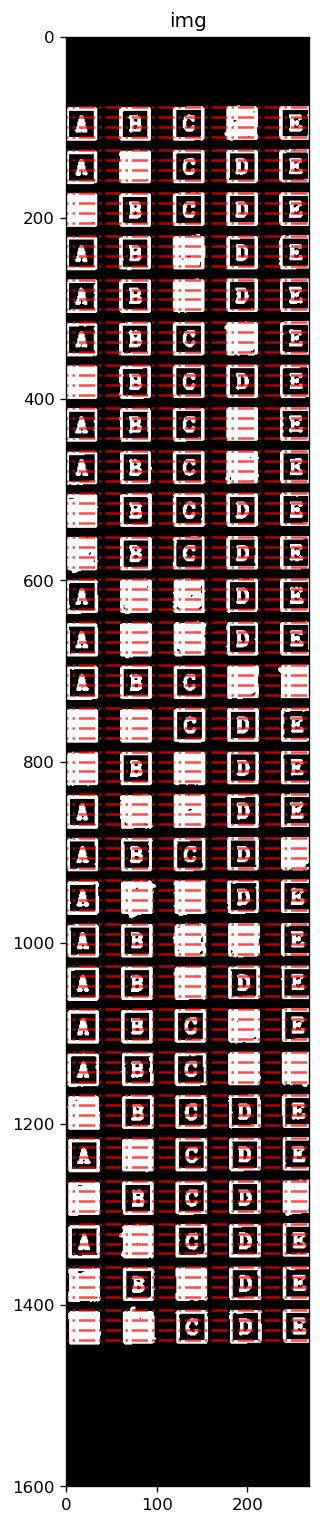

In [242]:
show_lines(p, horizontal_lines_merged)

Other test images

In [168]:
def grid_lines(fname):
    im = cv2.imread(fname)
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5,5), 0)
    blurred_cropped = blurred[600:, :]
    (T, threshinv) = cv2.threshold(blurred_cropped, 200, 255, cv2.THRESH_BINARY_INV)
    
    lines = cv2.HoughLines(threshinv,1/4,np.pi/(4*180),300)
    sorted_lines = lines.squeeze()[np.argsort(np.abs(lines.squeeze()[:,0]))]
    vertical_lines = sorted_lines[slope_close_to(sorted_lines[:,1], 0, tol=15)]
    vertical_lines_merged = vertical_lines[merge_lines(vertical_lines, ro_tol=10)]
    
    lines = cv2.HoughLines(threshinv,1/4,np.pi/(4*180),250)
    sorted_lines = lines.squeeze()[np.argsort(np.abs(lines.squeeze()[:,0]))]
    horizontal_lines = sorted_lines[slope_close_to(sorted_lines[:,1], 90, tol=15)]
    horizontal_lines_merged = horizontal_lines[merge_lines(horizontal_lines, ro_tol=10)]
    
    show_lines(threshinv, np.vstack((vertical_lines_merged, horizontal_lines_merged)), fname)

a-30.jpg
a-27.jpg
c-33.jpg
c-18.jpg
a-3.jpg
b-13.jpg
a-48.jpg
b-27.jpg
blank_form.jpg


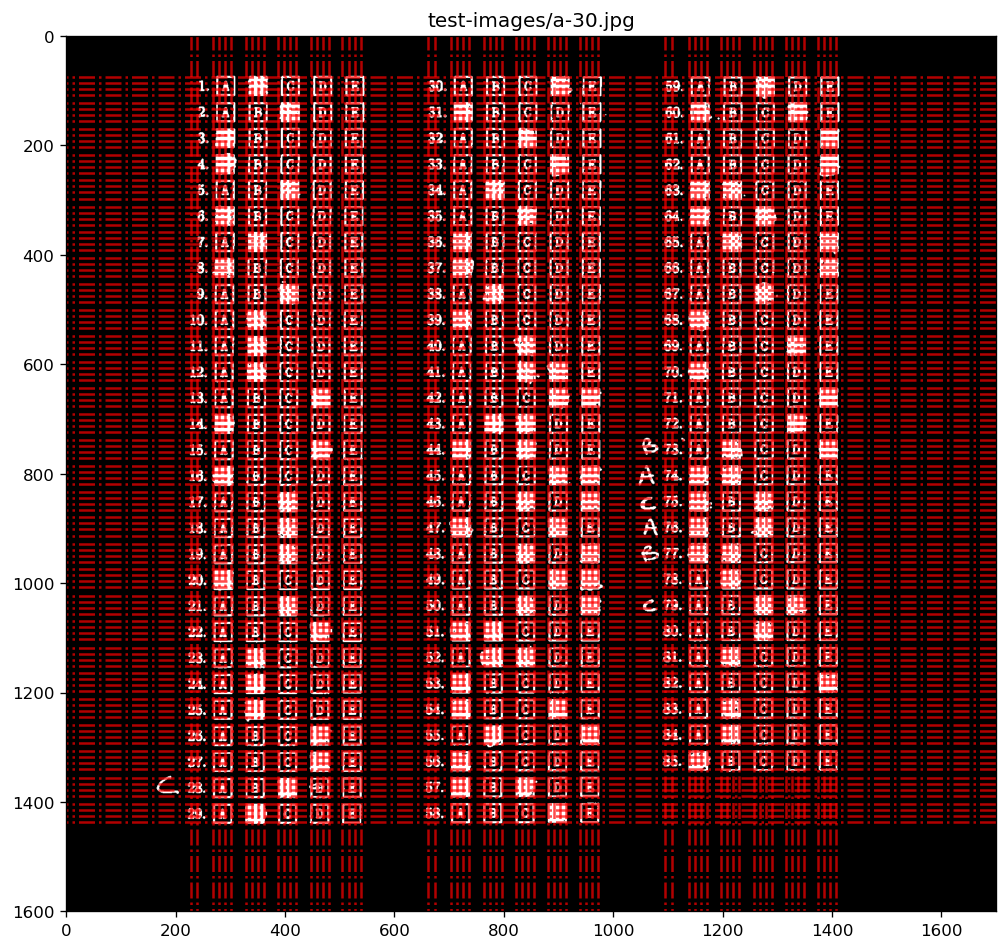

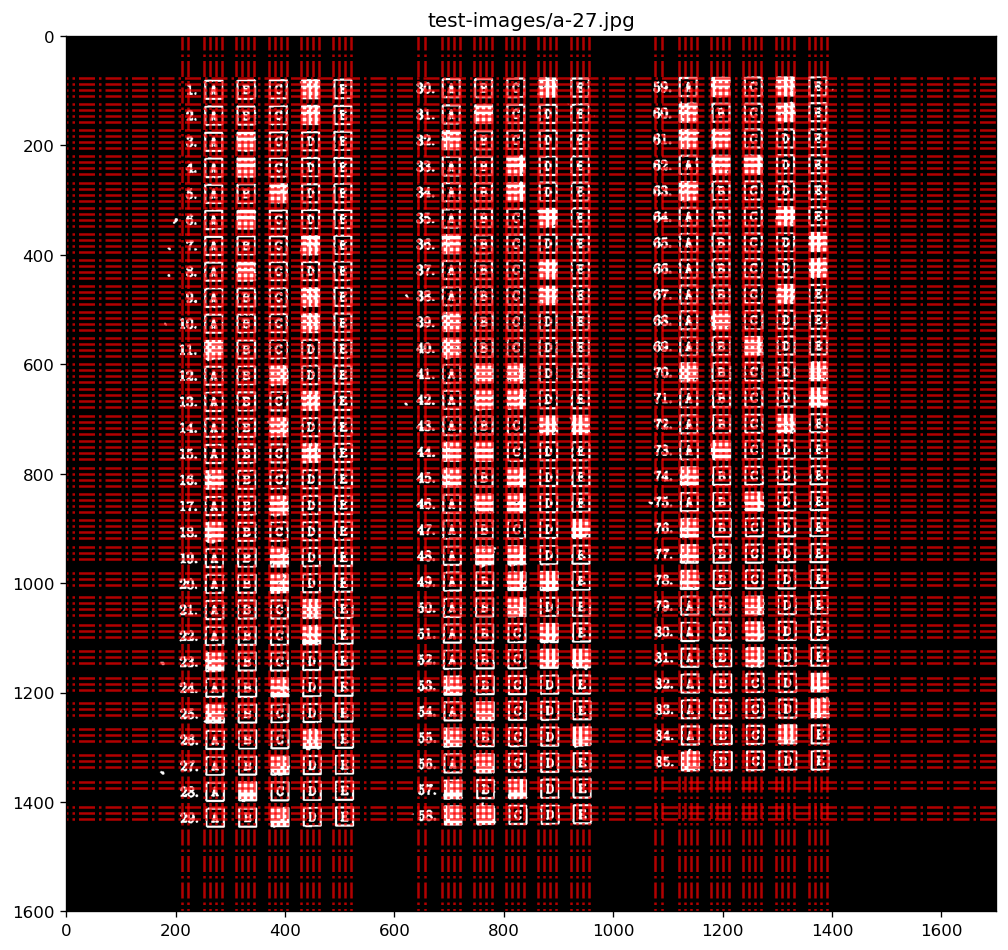

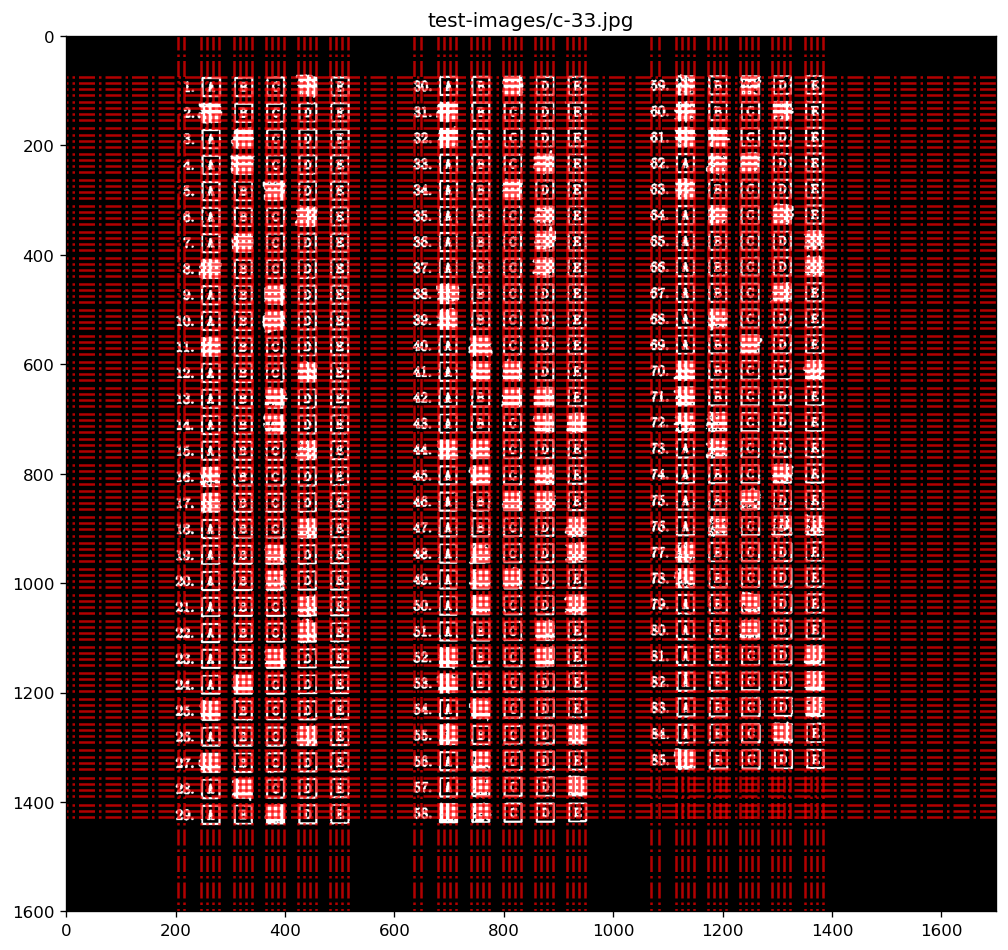

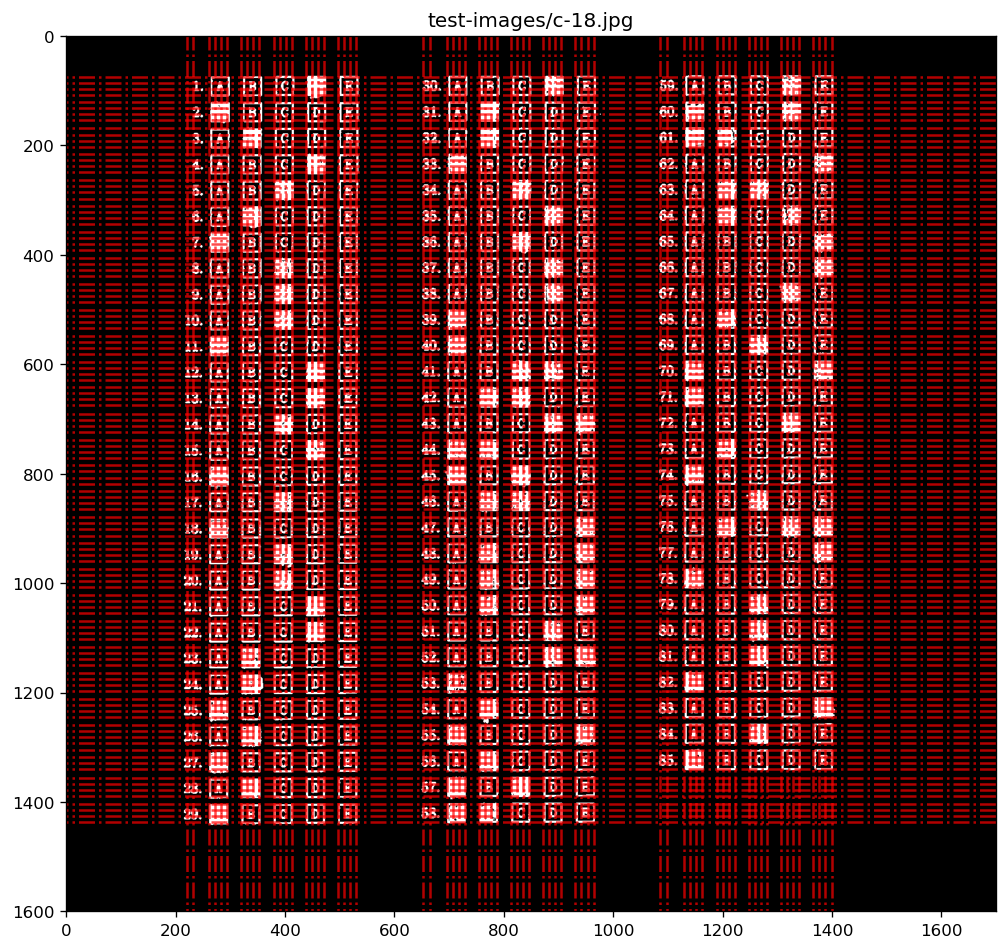

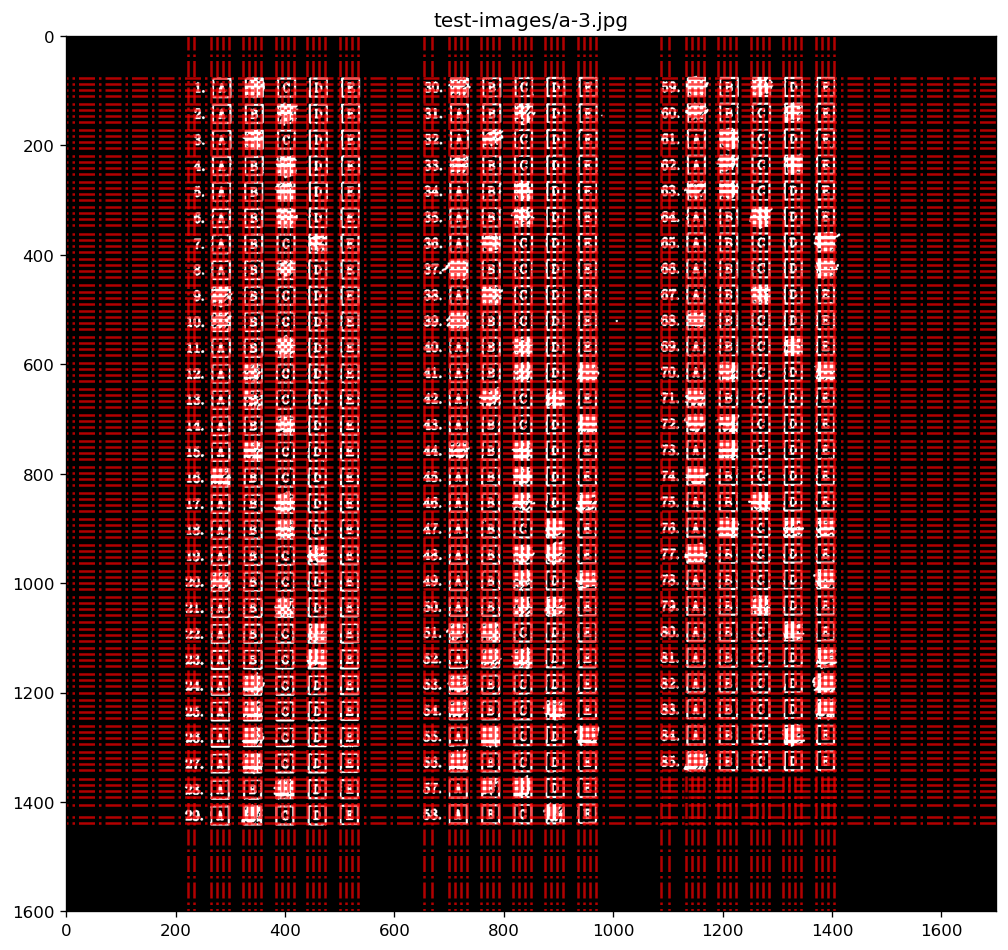

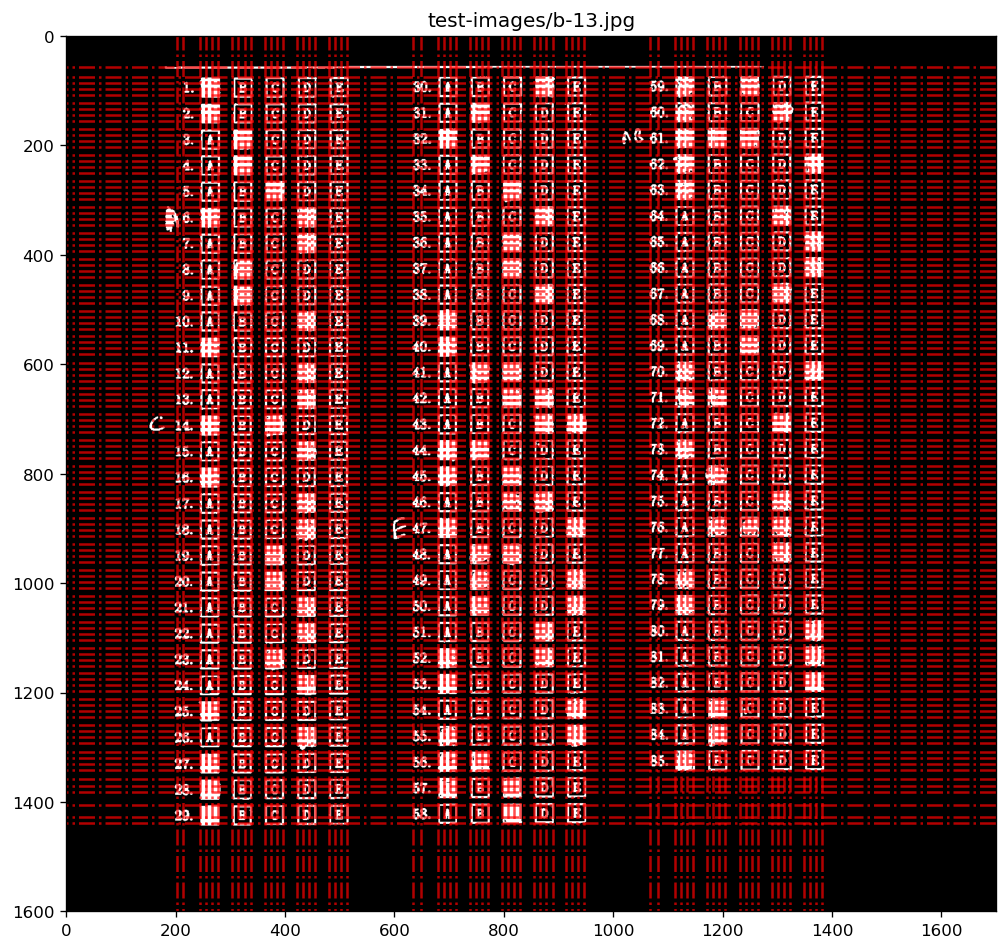

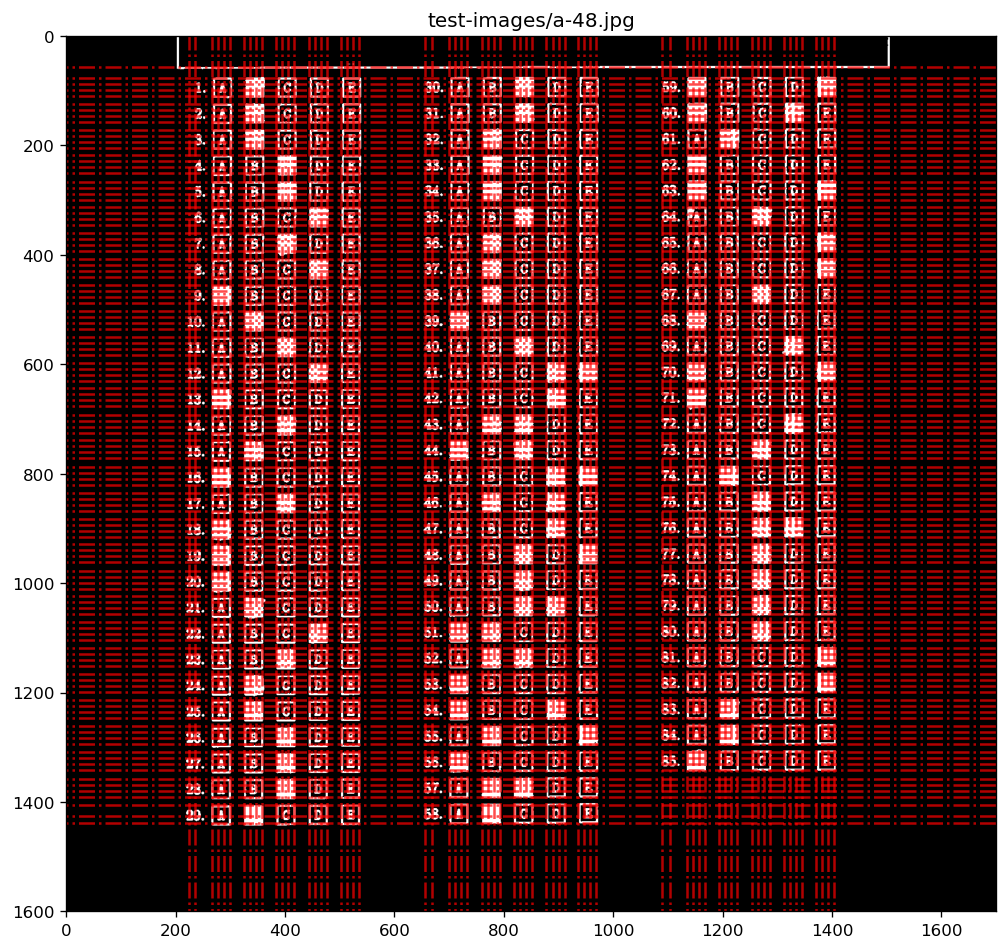

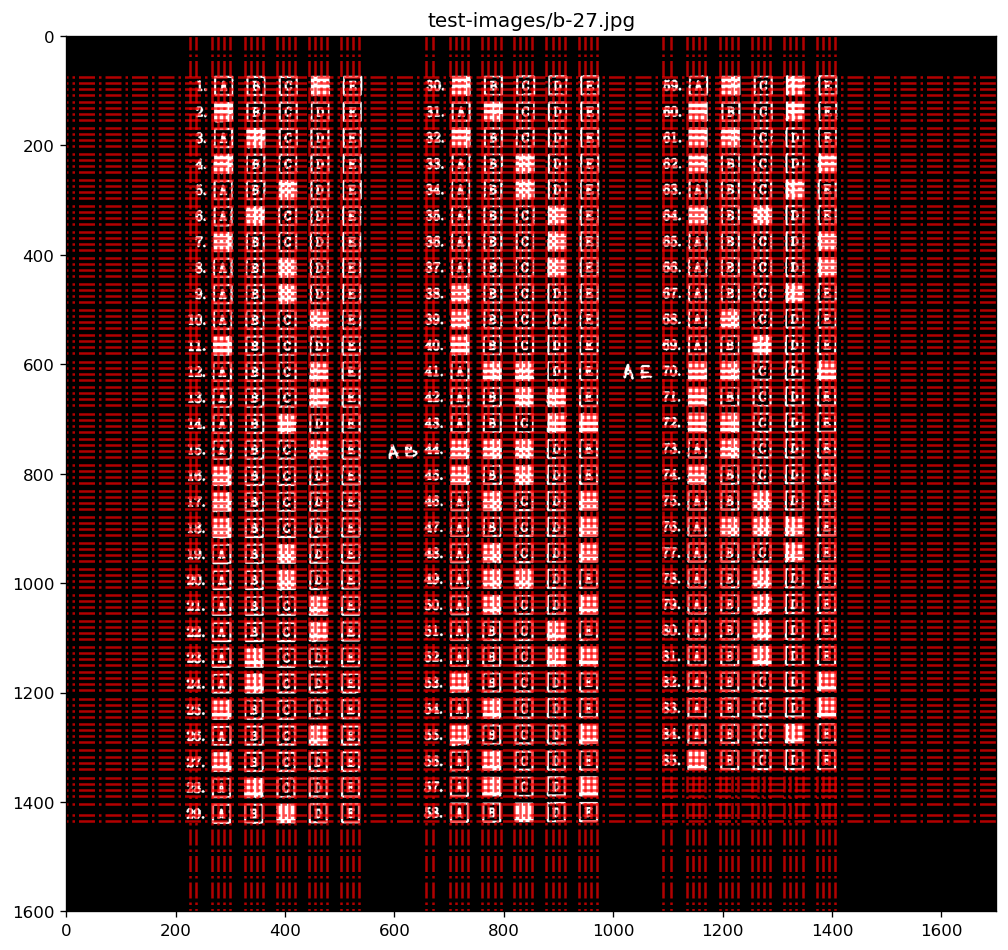

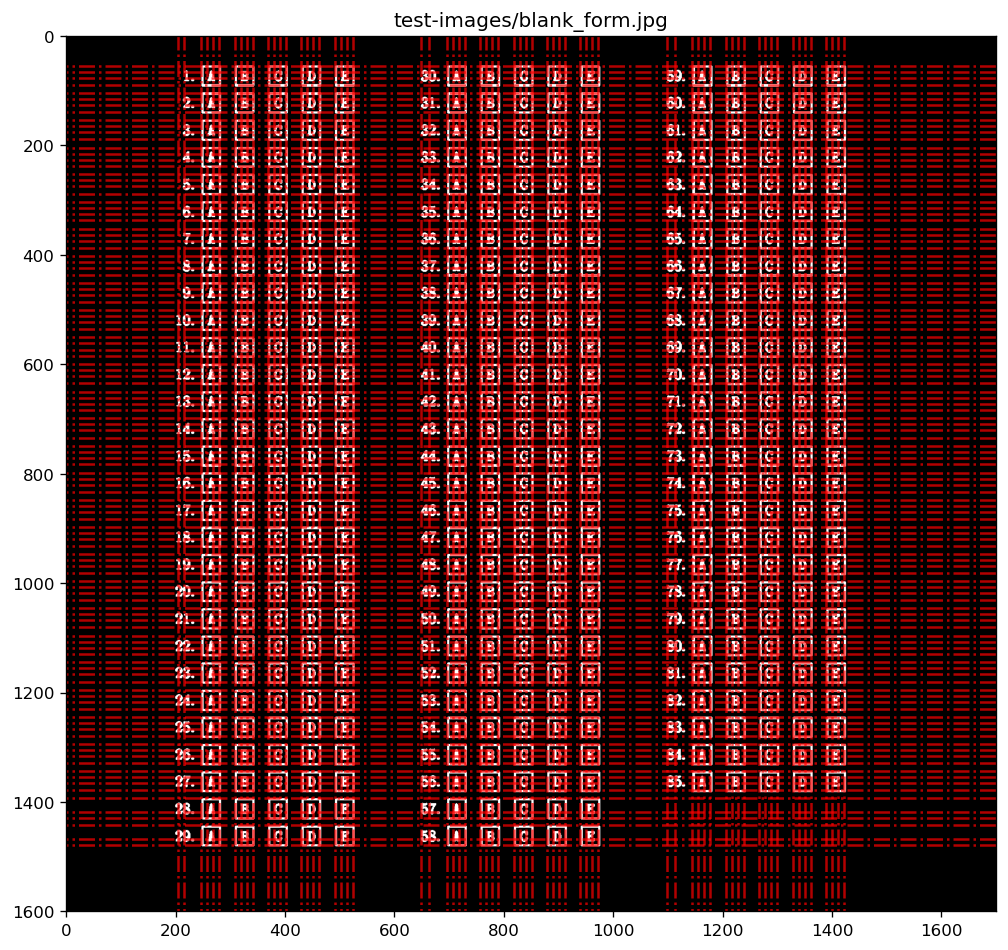

In [169]:
for fname in [fname for fname in os.listdir('test-images') if fname.endswith('.jpg')]:
    print(fname)
    grid_lines('test-images/'+fname)

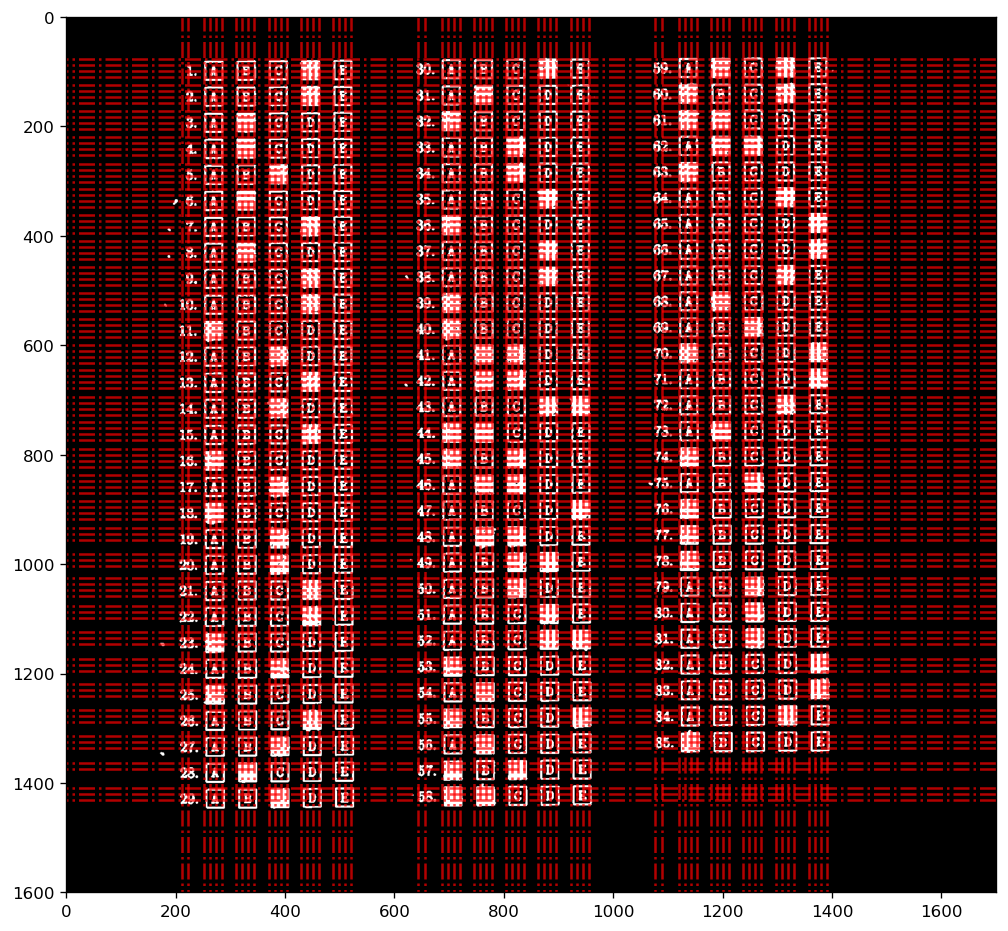

In [162]:
grid_lines('test-images/a-27.jpg')